In [116]:
# libraries needed
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D, AveragePooling2D

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from matplotlib import pyplot as plt

import cv2

In [43]:
#run this cell to convert zip file into required dataset we want
#!unzip "/content/drive/MyDrive/Datasets/Face Mask/dataset.zip" -d "/content/drive/MyDrive/Datasets/Face Mask/"

# Data Preparation & Augmentation

In [44]:
train_path = "/content/drive/MyDrive/Datasets/Face Mask/dataset"

count = 0

for folder in sorted(os.listdir(train_path)):
  if folder == ".DS_Store":
    continue
    
  for img in sorted(os.listdir(os.path.join(train_path, folder))):
    count += 1

  print(f"{folder} has {count} images")

  count = 0

with_mask has 1915 images
without_mask has 1918 images


In [45]:
train = ImageDataGenerator(rotation_range=20,
                            zoom_range=0.15,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            horizontal_flip=True,
                            validation_split=0.2)

In [46]:
training_data = train.flow_from_directory(train_path,
                                          target_size=(224, 224),
                                          class_mode='categorical',
                                          subset="training")

Found 3067 images belonging to 2 classes.


In [47]:
validation_data = train.flow_from_directory(train_path,
                                          target_size=(224, 224),
                                          class_mode='categorical',                                          
                                          subset="validation")

Found 766 images belonging to 2 classes.


In [103]:
training_data.class_indices

{'with_mask': 0, 'without_mask': 1}

# CCN Architecture

In [48]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
Head = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [50]:
for layer in Head.layers:
	layer.trainable = False

In [51]:
base = Sequential()

In [52]:
base.add(
    Head
)

In [53]:
base.add(
    AveragePooling2D(pool_size=(7,7))
)

In [54]:
base.add(
    Flatten()
)

In [55]:
base.add(
    Dense(128, activation="relu")
)

In [56]:
base.add(
    Dropout(0.5)
)

In [57]:
base.add(
    Dense(2, activation="softmax")
)

In [58]:
base.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 2,422,210
Trainable params: 164,226
Non-trainable params: 2,257,984
______________________________________

In [61]:
base.compile(loss="binary_crossentropy", 
              optimizer="adam",
              metrics=["accuracy"])

In [63]:
history = base.fit_generator(training_data,
                             epochs=20,
                             validation_data=validation_data)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
50/96 [==============>...............] - ETA: 20s - loss: 0.6477 - accuracy: 0.6868

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


96/96 [==============================] - 56s 553ms/step - loss: 0.5766 - accuracy: 0.7334 - val_loss: 0.3084 - val_accuracy: 0.8786
Epoch 2/20
96/96 [==============================] - 52s 546ms/step - loss: 0.3497 - accuracy: 0.8623 - val_loss: 0.2977 - val_accuracy: 0.8877
Epoch 3/20
96/96 [==============================] - 53s 548ms/step - loss: 0.3066 - accuracy: 0.8850 - val_loss: 0.2525 - val_accuracy: 0.9008
Epoch 4/20
96/96 [==============================] - 53s 548ms/step - loss: 0.2816 - accuracy: 0.8915 - val_loss: 0.2225 - val_accuracy: 0.9060
Epoch 5/20
96/96 [==============================] - 52s 545ms/step - loss: 0.2583 - accuracy: 0.9088 - val_loss: 0.2185 - val_accuracy: 0.9191
Epoch 6/20
96/96 [==============================] - 53s 548ms/step - loss: 0.2418 - accuracy: 0.9122 - val_loss: 0.1944 - val_accuracy: 0.9243
Epoch 7/20
96/96 [==============================] - 52s 545ms/step - loss: 0.2349 - accuracy: 0.9036 - val_loss: 0.1737 - val_accuracy: 0.9347
Epoch 8/20

In [143]:
base.save("/content/drive/MyDrive/Colab Notebooks/fask_mask_detector.h5")

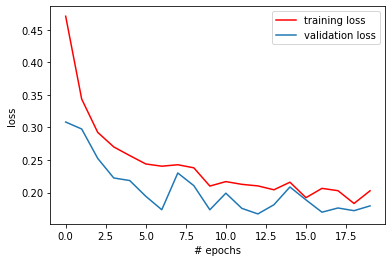

In [65]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

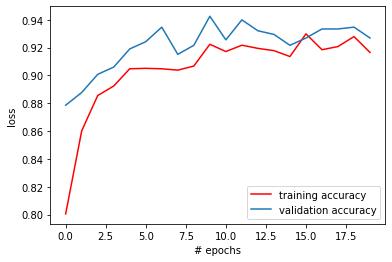

In [66]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Testing on Images

In [121]:
def predict(img_path):

  prediction = []

  img = cv2.imread(test_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224,224))
  img = img_to_array(img)
  img = img.reshape(1, 224, 224, 3)

  predicted_class = base.predict_classes(img)
  predicted_class_proba = round(max(base.predict(img)[0])*100, 2)

  # "{'with_mask': 0, 'without_mask': 1}"

  if predicted_class[0] == 1:
    prediction.append('No Mask')

  else:
    prediction.append('Mask')

  prediction.append(predicted_class_proba)

  return(prediction)

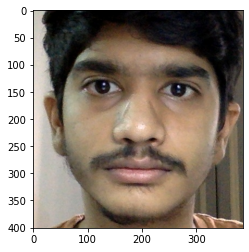

['No Mask', 100.0]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [140]:
test_path = '/content/drive/MyDrive/Datasets/Face Mask/Test/akshit_3.jpg'

plt.imshow(cv2.cvtColor(cv2.imread(test_path), cv2.COLOR_BGR2RGB))
plt.show()

print(predict(test_path))

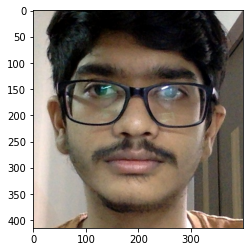

['No Mask', 72.85]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [141]:
test_path = '/content/drive/MyDrive/Datasets/Face Mask/Test/akshit_2.jpg'

plt.imshow(cv2.cvtColor(cv2.imread(test_path), cv2.COLOR_BGR2RGB))
plt.show()

print(predict(test_path))

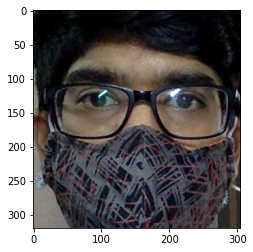

['Mask', 100.0]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [139]:
test_path = '/content/drive/MyDrive/Datasets/Face Mask/Test/akshit_9.jpg'

plt.imshow(cv2.cvtColor(cv2.imread(test_path), cv2.COLOR_BGR2RGB))
plt.show()

print(predict(test_path))

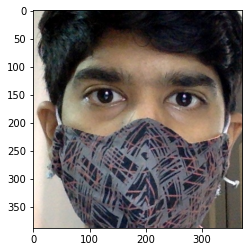

['Mask', 75.56]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [142]:
test_path = '/content/drive/MyDrive/Datasets/Face Mask/Test/akshit_6.jpg'

plt.imshow(cv2.cvtColor(cv2.imread(test_path), cv2.COLOR_BGR2RGB))
plt.show()

print(predict(test_path))